# Vertical heat transport

**Explanation**: Vertical analysis of the CSHT can be misleading, because it assumes the budget calcualted with the zonal convergence, occurs in the same level. This is a biased assumption since not all heat coming from the eastern edge of each bin, will leave the western edge at the same depth ([check this GH post](https://github.com/willaguiar/ASC_and_heat_transport/issues/21)).

**Proposed fix**: TO fix the problem we can calculate the vertical heat transport. This vertical heat transport on the shelf can be discoutned whn slicing the domain vertically, on the top edge of the slice, or a vertical convergence can be calculated and added to each ocean level, to fully close the heat budget on the shelf. We will try to do this here.

In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=28); client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35495,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:38243,Total threads: 1
Dashboard: /proxy/41827/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:42249,


## 1 - Importing vars

#### 1.1 Dates, sessions and cutoff lats

In [3]:
	session = cc.database.create_session()
	
	
	imm=1
	monthdays = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
	month = str(int(imm))
	month = month.zfill(2)
	year = str(1958)
	start_time=year+'-'+month  
	#Start_time0 and end_time0 are for importing the daily transport, and it ahsthe number of days in the month    
	start_time0=year+'-'+month +'-01'     
	end_time0=year+'-'+month +'-' + str(monthdays[int(int(imm)-1)])
	print(start_time0) 
	print(end_time0) 
	exp = '01deg_jra55v140_iaf_cycle3'
	
	print("Start date =" + start_time) 
	year2=str(int(start_time[0:4])+1)
	month2=str(int(start_time[5:7])+1)
	month2=str(int(month2))
	month2 = month2.zfill(2)    
	print("month2 is =" + month2) 
	print("year2 is =" + str(year2))     
	
	imon = int(imm)
	if imon <12:
		end_time=year+'-'+month2
	else:
		end_time=year2+'-01'
	
	print("End date =" + end_time) 
	
	
	time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))
	
	# reference density value:
	rho_0 = 1035.0
	# specific heat capacity of sea water:
	cp = 3992.1
	lat_range = slice(-90,-59)
	
	isobath_depth = 1000
	
	# pick a freezing point temp:
	temp_freezing = -3.82
	
	

1958-01-01
1958-01-31
Start date =1958-01
month2 is =02
year2 is =1959
End date =1958-02


#### 1.2 Vertical velocities,temperatures and spacings

We have a variable called *wt* , which is called dia-surface velocity T-points [m/sec]. Is that the velocity we want? not quite sure, but lets try

In [4]:
wt = cc.querying.getvar(exp,'wt',session,start_time=start_time,end_time=end_time).sel(time=start_time).sel(yt_ocean=lat_range).mean('time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


We will also need temperatures

In [5]:
temp = cc.querying.getvar(exp,'temp',session,frequency='1 monthly',start_time=start_time,end_time=end_time
                         ).sel(time=start_time).sel(yt_ocean=lat_range).mean('time') -273.15 + temp_freezing

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Notice that the freezing point was already discounted in the variable, so we dont need to calculate that extra variable. Lets now interpolat temp to sw_ocean

In [6]:
temp = temp.interp(st_ocean=wt.sw_ocean)

We will also need the cross-sectional surface area

In [7]:
area_t = cc.querying.getvar(exp,'area_t',session,n=1)

## 2 - Calculating tz_trans and vertical convergence

#### 2.1 Tz_trans, the vertical heat transport

The vertical heat transport will be....

In [8]:
tz_trans= cp*rho_0*wt*area_t*temp

In [9]:
tz_trans = tz_trans.load()

#### 2.2 Importing vars to calculate the vertical convergence

contour_masks

In [10]:
	
	print("importing isobath mask")
	outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
	data = np.load(outfile)
	mask_y_transport = data['mask_y_transport']
	mask_x_transport = data['mask_x_transport']
	mask_y_transport_numbered = data['mask_y_transport_numbered']
	mask_x_transport_numbered = data['mask_x_transport_numbered']
	
	yt_ocean = cc.querying.getvar(exp,'yt_ocean',session,n=1)
	yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
	yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
	yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
	xt_ocean = cc.querying.getvar(exp,'xt_ocean',session,n=1)
	xu_ocean = cc.querying.getvar(exp,'xu_ocean',session,n=1)   
	
	mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yt_ocean",dim_1="xu_ocean")
	mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yu_ocean",dim_1="xt_ocean")
	mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
	mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
	
	num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))
	lat_along_contour = np.zeros((num_points))
	lon_along_contour = np.zeros((num_points))
	
	# locations for zonal transport:
	x_indices_masked = mask_x_transport_numbered.stack().values
	x_indices = np.sort(x_indices_masked[x_indices_masked>0])
	for count in x_indices:
		count = int(count)
		jj = int(np.where(mask_x_transport_numbered==count)[0])
		ii = int(np.where(mask_x_transport_numbered==count)[1])   
		lon_along_contour[count-1] = xu_ocean[ii].values
		lat_along_contour[count-1] = mask_x_transport_numbered.yt_ocean[jj].values
	
	# locations for meridional transport:
	y_indices_masked = mask_y_transport_numbered.stack().values
	y_indices = np.sort(y_indices_masked[y_indices_masked>0])
	for count in y_indices:
		count = int(count)
		jj = np.where(mask_y_transport_numbered==count)[0]
		ii = np.where(mask_y_transport_numbered==count)[1]
		lon_along_contour[count-1] = mask_x_transport_numbered.xt_ocean[ii].values
		lat_along_contour[count-1] = yu_ocean[jj].values
	

importing isobath mask


In [11]:
	cutout_latind=510
	########### Import Adeles 1km contour on X,Y grid                
	outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
	data = np.load(outfile)
	mask_y_transport = data['mask_y_transport']; 
	mask_y_transport=mask_y_transport[:cutout_latind,:]       ##############################
	mask_x_transport = data['mask_x_transport']; 
	mask_x_transport=mask_x_transport[:cutout_latind,:]		################################
	mask_y_transport_numbered = data['mask_y_transport_numbered']
	mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################
	mask_x_transport_numbered = data['mask_x_transport_numbered']
	mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################
	
	
	#cutting the matrices
	ylength= np.shape(mask_x_transport)[0]
	
	
	yt_ocean0 = cc.querying.getvar(exp,'yt_ocean',session,n=1)
	yt_ocean0 = yt_ocean0.isel(yt_ocean=slice(0,ylength))
	yu_ocean0 = cc.querying.getvar(exp,'yu_ocean',session,n=1)
	yu_ocean0 = yu_ocean0.isel(yu_ocean=slice(0,ylength))
	xt_ocean0 = cc.querying.getvar(exp,'xt_ocean',session,n=1)
	xu_ocean0 = cc.querying.getvar(exp,'xu_ocean',session,n=1)
	

The vertical convergence will be the sum of everything crossing a specific level (st_ocean) in that specific bin. To make this some we will first need to mask any value north of the isobath. LEts create this mask then

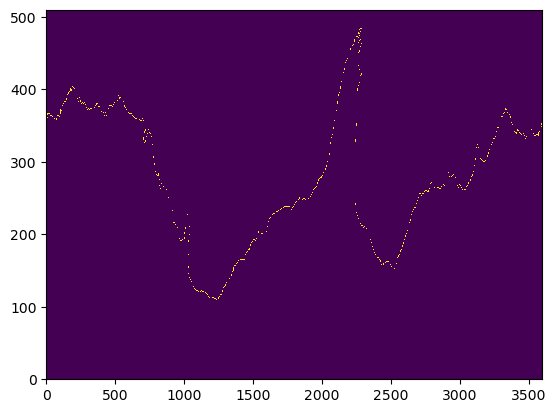

In [12]:
plt.pcolormesh(mask_y_transport_numbered+mask_x_transport_numbered,vmin=0,vmax=1); 

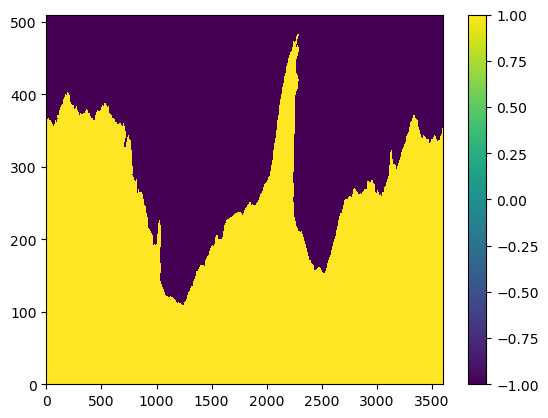

In [13]:
mask=data['contour_masked_above']-data['contour_mask_numbered']
mask[mask>=0]=1
mask[mask<0]=-1; 
mask3=np.zeros(np.shape(mask)); mask3[:-2,:]=mask[2:,:]
#mask=np.ma.masked_where(mask<0,mask)+1
mask=mask3
plt.pcolormesh(mask)
plt.colorbar()

In [14]:
	data_mask=xr.DataArray(mask,name="mask_shelf",dims=["yt_ocean","xt_ocean"])
	data_mask['xt_ocean']=tz_trans.xt_ocean
	data_mask['yt_ocean']=tz_trans.yt_ocean

In [15]:
#masking off-shelf locations
tz_trans_masked=tz_trans.where(data_mask>0).where(tz_trans.sw_ocean<2082)

In [16]:
	
	# convert to longitude coordinate and average into 3 degree longitude bins:
	# in degrees:
	bin_width = 3
	bin_spacing = 0.25
	lon_west = -280
	lon_east = 80
	
	# new coordinate and midpoints of longitude bins:
	full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
	lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
	lon_bin_west = np.arange(lon_west,lon_east-bin_width,bin_spacing)
	lon_bin_east = np.arange(lon_west+bin_width,lon_east+bin_width,bin_spacing)
	n_bin_edges = len(full_lon_coord)

The cell below is the slowest one (~ 10 min). 

In [17]:
n_bins=int(np.size(lon_bin_midpoints)); n_bins

1428

In [18]:
	%%time
	vertical_heat_trans_deep = np.zeros([75,n_bins])
	vertical_heat_trans_shallow = np.zeros([75,n_bins])
	print('calculation percentage =')
	for lon_bin in range(n_bins):
		#separating the right slice for the bin
		VHT_bin = tz_trans_masked.where((xt_ocean>=lon_bin_west[lon_bin]) & (xt_ocean<=lon_bin_east[lon_bin]),drop=True)
		vertical_heat_trans_deep[:,lon_bin]=VHT_bin.sum('yt_ocean').sum('xt_ocean')
		print(str(int((lon_bin/1428)*100)) + '%', end='\r')



calculation percentage =
CPU times: user 6min 18s, sys: 6min 31s, total: 12min 50s
Wall time: 10min 11s


For a cell at depth st_ocean(n), the bottom of the cell will be sw_ocean(n), and the top will be sw_ocean(n-1). And since there are no vertical fluxes at the surface, we can just assume the at n=0, the tz_trans=0 everywhere. Therefore, we can get the heat transport in the surface of teh cell by doing the following:

In [19]:
vertical_heat_trans_shallow[1:,:]=vertical_heat_trans_deep[:-1,:]

In [20]:
vertical_convergence=vertical_heat_trans_shallow-vertical_heat_trans_deep

The vertical heat convergence will then be:

## 3 - Cross-slope heat transport with and without vertical convergence

How do they differ for this specific month in analysis

In [21]:
#Importing it
file_csht='/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/Ant_cross_slope_heat_terms_offline_1000m_'+start_time+'.nc'
HT_month=xr.open_dataset(file_csht).mean('time')
HT_month

<xarray.Dataset>
Dimensions:                              (st_ocean: 75,
                                          lon_bin_midpoints: 1428,
                                          contour_index: 6002)
Coordinates:
  * st_ocean                             (st_ocean) float64 0.5413 ... 5.709e+03
    TLON                                 (contour_index) float32 ...
    TLAT                                 (contour_index) float32 ...
    ULON                                 (contour_index) float32 ...
    ULAT                                 (contour_index) float32 ...
  * contour_index                        (contour_index) int64 1 2 ... 6001 6002
  * lon_bin_midpoints                    (lon_bin_midpoints) float64 -278.5 ....
Data variables:
    zonal_convergence                    (st_ocean, lon_bin_midpoints) float64 ...
    binned_cross_slope_heat_trans        (st_ocean, lon_bin_midpoints) float64 ...
    unbinned_heat_transp_across_contour  (st_ocean, contour_index) float32 -3...
    lat_along_contour                    (contour_index) float64 -66.01 ... -...
    lon_along_contour                    (contour_index) float64 -279.9 ... 80.0
    lat_bin_midpoints                    (lon_bin_midpoints) float64 -65.63 ....

In [22]:
#Separating variables
unbinned_CSHT=HT_month.unbinned_heat_transp_across_contour
binned_CSHT=HT_month.binned_cross_slope_heat_trans
binned_ZC=HT_month.zonal_convergence

Calculating factors

In [23]:
f_ZC=unbinned_CSHT.sum()/(binned_CSHT.sum()+binned_ZC.sum())
#this factor below includes the vertical convergence calculations. 
f_ZVC= unbinned_CSHT.sum()/(binned_CSHT.sum()+binned_ZC.sum()-np.sum(vertical_convergence))

#do they differ?
f_ZC,f_ZVC

(<xarray.DataArray ()>
 array(0.08551289),
 <xarray.DataArray ()>
 array(0.08551289))

As expected, theya re the exact same value, as the vertical convergence dont overlap things on total, only vertically. That means that in terms of total CSHT ( integrated in depth, and contour, mean in time), they should be the same.

Notice that the vertical convergence have to be diminished from the signal, instead of added, because of the way that it was calculated (top - bottom, with vertical velocity postive upwards

In [24]:
#After factoring the CSHT will be:
CSHT_ZC=(binned_CSHT+binned_ZC)*f_ZC
CSHT_VZC=(binned_CSHT+binned_ZC-vertical_convergence)*f_ZC

In [25]:
#we expect the sum of the vertical convergence to be approximately 0. is it?
print( 'Sum of vertical convergence = ' + str(int(np.sum(vertical_convergence))) + ' TW')

Sum of vertical convergence = 0 TW


(1500.0, 0.0)

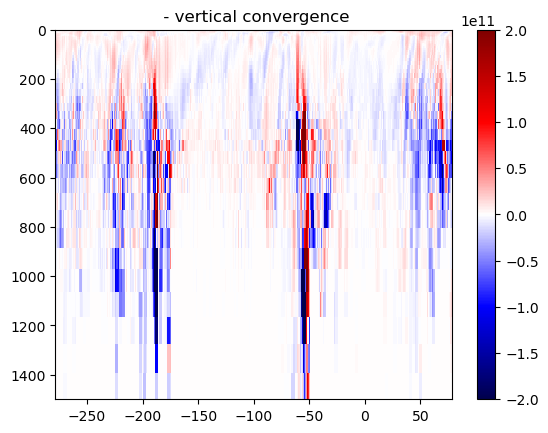

In [26]:
#HOW DOES THE VERTICAL CONVERGENCE LOOK LIKE?
plt.pcolormesh(lon_bin_midpoints,HT_month.st_ocean,-vertical_convergence*float(f_ZC),cmap='seismic',vmin=-2e11,vmax=2e11); 
plt.colorbar(); plt.title( " - vertical convergence")
plt.ylim(1500,0)

How does the vertical convergence looks like compared to the CSHT, and zonal convergence?

Why is there a band of heat divergence around the 1km isobath? This would denove that heat is being continuously lost at the 1km isobath. Also why do we have values extending to 3000m depth? if this is along the 1km siobath, there should be a cutoff there. maybe the mask is displaced too much northwards?

Text(0, 0.5, 'depth')

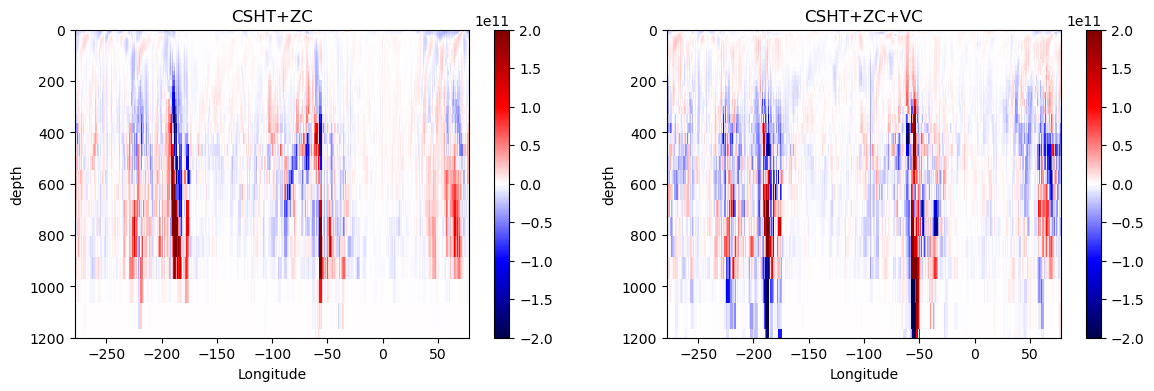

In [27]:
fig = plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.pcolormesh(lon_bin_midpoints,HT_month.st_ocean,CSHT_ZC,cmap='seismic',vmin=-2e11,vmax=2e11)
plt.colorbar(); 
plt.ylim(1200,0)
plt.title('CSHT+ZC'); plt.xlabel('Longitude');plt.ylabel('depth')


plt.subplot(1,2,2)
plt.pcolormesh(lon_bin_midpoints,HT_month.st_ocean,CSHT_VZC,cmap='seismic',vmin=-2e11,vmax=2e11)
plt.colorbar(); 
plt.ylim(1200,0)
plt.title('CSHT+ZC+VC'); plt.xlabel('Longitude');plt.ylabel('depth')

In [28]:
print('CSHT + ZC = ' +str(int(CSHT_ZC.sum()/1e12)) + 'TW /n CSHT + ZC +VC = ' +str(int(CSHT_VZC.sum()/1e12)) + 'TW' )

CSHT + ZC = -53TW /n CSHT + ZC +VC = -53TW


Assuming all calculations are correct, it seems that vertical convergence does make a difference in the vertical profile

It seems that the vertical convergence is very concentrated in a few regions of the model. I want to see how much these correlate with locations of DSW formation

In [29]:
DSWdir='/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports'
gl =sorted(glob.glob(DSWdir + "/01deg_jra55v13_ryf9091_21mbath/Antarctic_cross_slope/*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans=expt0_voltrans.mean('time').load()

120 netcdf data files


In [30]:
expt0_voltrans_above27_8=expt0_voltrans.where(expt0_voltrans.isopycnal_bins>27.8).sum('isopycnal_bins')

Text(0, 0.5, 'Cross-slope mass transport [SV]')

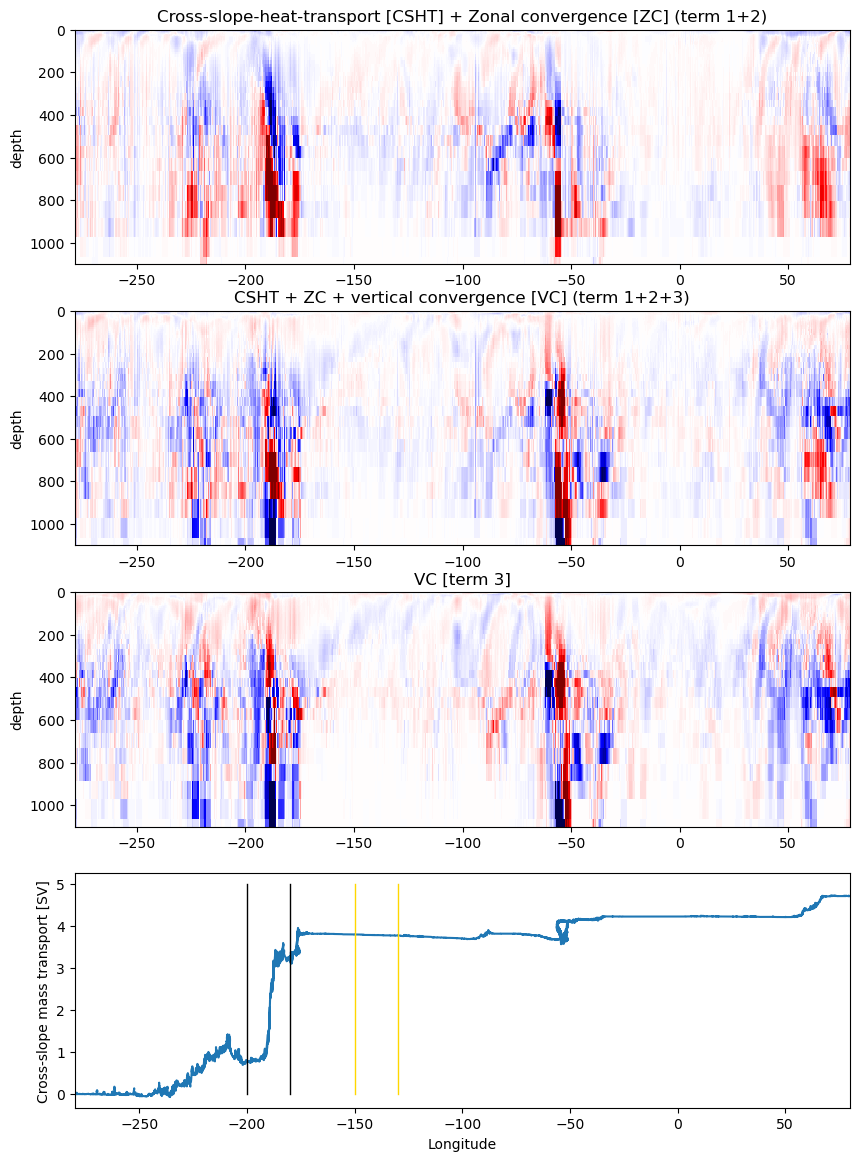

In [31]:
fig = plt.figure(figsize=(10,14))

plt.subplot(4,1,1)
plt.pcolormesh(lon_bin_midpoints,HT_month.st_ocean,CSHT_ZC,cmap='seismic',vmin=-2e11,vmax=2e11)
#plt.colorbar(); 
plt.ylim(1100,0)
plt.title('Cross-slope-heat-transport [CSHT] + Zonal convergence [ZC] (term 1+2)');plt.ylabel('depth')

plt.subplot(4,1,2)
plt.pcolormesh(lon_bin_midpoints,HT_month.st_ocean,CSHT_VZC,cmap='seismic',vmin=-2e11,vmax=2e11)
#plt.colorbar(); 
plt.ylim(1100,0)
plt.title('CSHT + ZC + vertical convergence [VC] (term 1+2+3)'); plt.ylabel('depth')


plt.subplot(4,1,3)
plt.pcolormesh(lon_bin_midpoints,HT_month.st_ocean,-vertical_convergence*float(f_ZC),cmap='seismic',vmin=-2e11,vmax=2e11)
#plt.colorbar(); 
plt.ylim(1100,0)
plt.title('VC [term 3]'); plt.ylabel('depth')


plt.subplot(4,1,4)
#plt.plot(lon_bin_midpoints,HT_month.lat_bin_midpoints)
plt.plot(HT_month.lon_along_contour,expt0_voltrans_above27_8.vol_trans_across_contour_binned.cumsum()/1e6)
plt.plot([-180,-180],[0,5],'k',lw=1); plt.plot([-200,-200],[0,5],'k',lw=1);
plt.plot([-130,-130],[0,5],'gold',lw=1); plt.plot([-150,-150],[0,5],'gold',lw=1);

plt.xlim(-280,80)
plt.xlabel('Longitude');plt.ylabel('Cross-slope mass transport [SV]')


Finally lets see how the CSHT profile looks like in two different regions, with and without DSW outflow

In [32]:
#Ross (-200,-180)
CSHT_ZC_Ross = CSHT_ZC.where((lon_bin_midpoints<=-180) & (lon_bin_midpoints>=-200)).sum('lon_bin_midpoints')
CSHT_VZC_Ross = CSHT_VZC.where((lon_bin_midpoints<=-180) & (lon_bin_midpoints>=-200)).sum('lon_bin_midpoints')
VC_Ross=CSHT_VZC_Ross - CSHT_ZC_Ross
#EA (-200,-180)
CSHT_ZC_A = CSHT_ZC.where((lon_bin_midpoints<=-130) & (lon_bin_midpoints>=-150)).sum('lon_bin_midpoints')
CSHT_VZC_A = CSHT_VZC.where((lon_bin_midpoints<=-130) & (lon_bin_midpoints>=-150)).sum('lon_bin_midpoints')
VC_A=CSHT_VZC_A - CSHT_ZC_A


Text(0.5, 1.0, 'Amundsen [150W to 130W]')

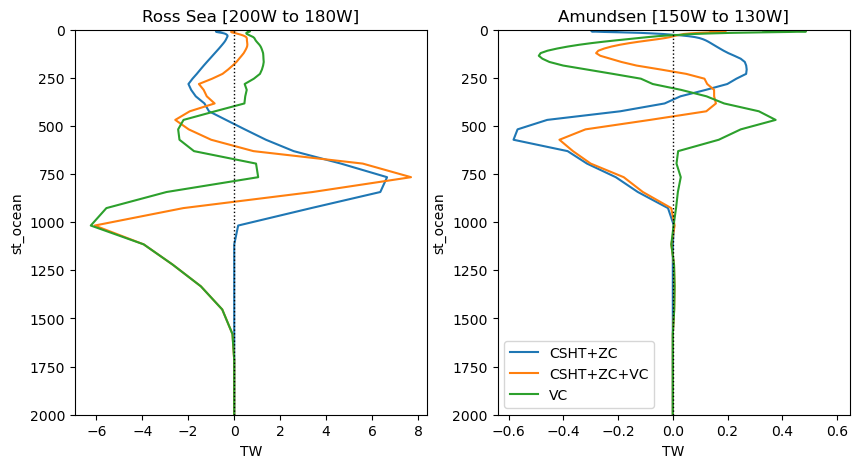

In [33]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
(CSHT_ZC_Ross/1e12).plot(y='st_ocean',label=r'CSHT+ZC'); 
(CSHT_VZC_Ross/1e12).plot(y='st_ocean',label=r'CSHT+ZC+VC'); 
(VC_Ross/1e12).plot(y='st_ocean',label=r'VC'); 
plt.plot([0,0],[2000,0],':',color='black',lw=1)
plt.ylim(2000,0);#plt.legend();
plt.xlabel('TW');
plt.title('Ross Sea [200W to 180W]')

plt.subplot(1,2,2)
(CSHT_ZC_A/1e12).plot(y='st_ocean',label=r'CSHT+ZC'); 
(CSHT_VZC_A/1e12).plot(y='st_ocean',label=r'CSHT+ZC+VC'); 
(VC_A/1e12).plot(y='st_ocean',label=r'VC'); 
plt.plot([0,0],[2000,0],':',color='black',lw=1)
plt.ylim(2000,0);plt.legend();plt.xlabel('TW');
plt.title('Amundsen [150W to 130W]')